<a href="https://colab.research.google.com/github/nedlecky/CSC485B/blob/main/CSC485_210_IrisClassifierStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 485B Spring 2023: CSC485_210_IrisClassifierStudy
## Try classifying the Iris dataset
* SUNY Plattsburgh, Spring 2023
* Dr. Ned Lecky
* nleck001@plattsburgh.edu
* ned@lecky.com


In [1]:
# Create our output directories
from pathlib import Path

OUTPUT_PATH = Path() / "iris_classifier"
IMAGES_PATH = Path() / OUTPUT_PATH / "images"

In [2]:
# Setup and Support Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import random

# This makes us reproducible (and we can adjust fixed_seed to get different results)
fixed_seed = 1

# Return n random floats between lo and hi as 1-column NumPy matrix
def rand_nlohi(n=1, lo=0, hi=1):
  # This is just a uniform distribution from lo to hi... we can adjust if appropriate in the future
  return (np.random.rand(n) * (hi - lo) + lo).reshape(-1,1)

# Often a good idea as long as we are keeping values near +/- 1... don't need exponential notation
np.set_printoptions(floatmode='fixed', precision=4, suppress=True)
# This will get us all 400 rows printed... which fails past 40 x 2 columns
np.set_printoptions(threshold=sys.maxsize)

# Simple numpy array print with optional push to file
def nprint(m, name='', also_write_file=False):
  print(f"{name} {m.shape} {m.dtype}")
  print(m)
  if also_write_file and name != '':
    fprint(m, name)

# Print numpy array to file (needs name)
def fprint(m, name='', path=OUTPUT_PATH):
  if name != '':
    with open(path /  name, 'w') as f:
      print(f"{name} {m.shape} {m.dtype}", file=f)
      print(m, file=f)
  else:
    print('fprint needs a name!')

# Remove a file and don't complain if it doesn't exist
def remove_file(name):
  try:
    os.remove(name)
  except:
    return

# Delete a directory, recursively removing files and subdirectories
def delete_directory(path):
  if not OUTPUT_PATH.exists():
    return

  print(f"delete_directory({path})")
  for file_name in os.listdir(path):
    # construct full file path
    file = path / file_name
    if os.path.isdir(file):
        print('  found subdirectory', file)
        delete_directory(file)
    elif os.path.isfile(file):
        print('  deleting file', file)
        os.remove(file)
  os.rmdir(path)

# Save a matplotlib figure to a png file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [3]:
# Setup (and clear) output directories
delete_directory(OUTPUT_PATH)

OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

delete_directory(iris_classifier)
  deleting file iris_classifier/X_train
  deleting file iris_classifier/y_train
  deleting file iris_classifier/X_train_std
  deleting file iris_classifier/X
  deleting file iris_classifier/X_test
  deleting file iris_classifier/Xy
  deleting file iris_classifier/y
  found subdirectory iris_classifier/images
delete_directory(iris_classifier/images)
  deleting file iris_classifier/images/tree.png
  deleting file iris_classifier/y_test
  deleting file iris_classifier/X_test_std
  deleting file iris_classifier/tree.png


Load the dataset.


In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
Xy = np.hstack([X,y.reshape(-1,1)])
fprint(X,"X")
fprint(y,"y")
fprint(Xy,"Xy")
print(f"feature_names = {data.feature_names}")
print(f"target_names = {data.target_names}")


feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
target_names = ['setosa' 'versicolor' 'virginica']


## Split the data... and see the value of stratifying


In [5]:
from sklearn.model_selection import train_test_split
def eval_datasets():
  print('Labels count in y:', np.bincount(y))
  print('Labels count in y_train:', np.bincount(y_train))
  print('Labels count in y_test:', np.bincount(y_test))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
print('No stratrification is BAD')
eval_datasets();

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print('Stratified: This is GOOD')
eval_datasets();

fprint(X_train, 'X_train')
fprint(X_test, 'X_test')
fprint(y_train, 'y_train')
fprint(y_test, 'y_test')


No stratrification is BAD
Labels count in y: [50 50 50]
Labels count in y_train: [36 32 37]
Labels count in y_test: [14 18 13]
Stratified: This is GOOD
Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


## Standardize the features

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
fprint(X_train_std, 'X_train_std')
fprint(X_test_std, 'X_test_std')

# Build an Evaluation Function

In [7]:
# Evaluation Function
from sklearn.metrics import accuracy_score

def evaluate(classifier):
  y_pred = classifier.predict(X_test_std)
  n_wrong = (y_test != y_pred).sum()
  n_total = y_pred.shape[0]
  print(f'Misclassified TEST examples: {n_wrong} of {n_total} ({100.0*(n_total-n_wrong)/n_total:.1f}% correct)')

  print(f'accuracy_score: {accuracy_score(y_test, y_pred):.3f}')
  print(f'classifier.score: {classifier.score(X_test_std, y_test):.3f}')

  y_pred_train = classifier.predict(X_train_std)
  n_wrong = (y_train != y_pred_train).sum()
  n_total = y_pred_train.shape[0]
  print(f'Misclassified TRAIN examples: {n_wrong} of {n_total} ({100.0*(n_total-n_wrong)/n_total:.1f}% correct)')

  print(f'accuracy_score: {accuracy_score(y_train, y_pred_train):.3f}')
  print(f'classifier.score: {classifier.score(X_train_std, y_train):.3f}')

def evaluate_raw(classifier):
  y_pred = classifier.predict(X_test)
  n_wrong = (y_test != y_pred).sum()
  n_total = y_pred.shape[0]
  print(f'Misclassified TEST examples: {n_wrong} of {n_total} ({100.0*(n_total-n_wrong)/n_total:.1f}% correct)')

  print(f'accuracy_score: {accuracy_score(y_test, y_pred):.3f}')
  print(f'classifier.score: {classifier.score(X_test_std, y_test):.3f}')

  y_pred_train = classifier.predict(X_train)
  n_wrong = (y_train != y_pred_train).sum()
  n_total = y_pred_train.shape[0]
  print(f'Misclassified TRAIN examples: {n_wrong} of {n_total} ({100.0*(n_total-n_wrong)/n_total:.1f}% correct)')

  print(f'accuracy_score: {accuracy_score(y_train, y_pred_train):.3f}')
  print(f'classifier.score: {classifier.score(X_train_std, y_train):.3f}')


# Training Classifiers

## Perceptron

In [8]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=10000, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)
evaluate(ppn)

Misclassified TEST examples: 2 of 45 (95.6% correct)
accuracy_score: 0.956
classifier.score: 0.956
Misclassified TRAIN examples: 7 of 105 (93.3% correct)
accuracy_score: 0.933
classifier.score: 0.933


## Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
evaluate(lr)


Misclassified TEST examples: 1 of 45 (97.8% correct)
accuracy_score: 0.978
classifier.score: 0.978
Misclassified TRAIN examples: 6 of 105 (94.3% correct)
accuracy_score: 0.943
classifier.score: 0.943


In [10]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
evaluate(svm)


Misclassified TEST examples: 1 of 45 (97.8% correct)
accuracy_score: 0.978
classifier.score: 0.978
Misclassified TRAIN examples: 3 of 105 (97.1% correct)
accuracy_score: 0.971
classifier.score: 0.971


## Alternative implementations

In [11]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
ppn.fit(X_train_std, y_train)
evaluate(ppn)

lr = SGDClassifier(loss='log')
lr.fit(X_train_std, y_train)
evaluate(lr)

svm = SGDClassifier(loss='hinge')
svm.fit(X_train_std, y_train)
evaluate(svm)


Misclassified TEST examples: 3 of 45 (93.3% correct)
accuracy_score: 0.933
classifier.score: 0.933
Misclassified TRAIN examples: 6 of 105 (94.3% correct)
accuracy_score: 0.943
classifier.score: 0.943
Misclassified TEST examples: 1 of 45 (97.8% correct)
accuracy_score: 0.978
classifier.score: 0.978
Misclassified TRAIN examples: 5 of 105 (95.2% correct)
accuracy_score: 0.952
classifier.score: 0.952
Misclassified TEST examples: 2 of 45 (95.6% correct)
accuracy_score: 0.956
classifier.score: 0.956
Misclassified TRAIN examples: 4 of 105 (96.2% correct)
accuracy_score: 0.962
classifier.score: 0.962


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


<br>
<br>

In [12]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
evaluate(svm)


Misclassified TEST examples: 2 of 45 (95.6% correct)
accuracy_score: 0.956
classifier.score: 0.956
Misclassified TRAIN examples: 5 of 105 (95.2% correct)
accuracy_score: 0.952
classifier.score: 0.952


In [13]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
evaluate(svm)


Misclassified TEST examples: 21 of 45 (53.3% correct)
accuracy_score: 0.533
classifier.score: 0.533
Misclassified TRAIN examples: 0 of 105 (100.0% correct)
accuracy_score: 1.000
classifier.score: 1.000


## Building a decision tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=6, 
                                    random_state=1)
tree_model.fit(X_train, y_train)
evaluate_raw(tree_model)



Misclassified TEST examples: 1 of 45 (97.8% correct)
accuracy_score: 0.978
classifier.score: 0.333
Misclassified TRAIN examples: 0 of 105 (100.0% correct)
accuracy_score: 1.000
classifier.score: 0.343


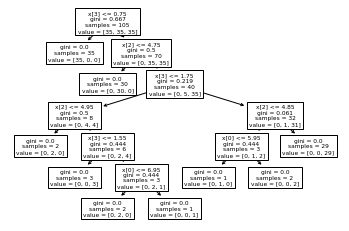

In [15]:
from sklearn import tree

tree.plot_tree(tree_model)
plt.show()

<br>
<br>

In [16]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['small', 
                                        'medium',
                                        'large'],
                           feature_names=['area', 
                                          'perimeter',
                                          'num_holes',
                                          'avg_holesize'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png(str(IMAGES_PATH / "tree.png"))

True

## Combine decision trees in a random forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',max_depth=6,verbose=1,random_state=1)
forest.fit(X_train, y_train)
evaluate_raw(forest)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Misclassified TEST examples: 1 of 45 (97.8% correct)
accuracy_score: 0.978
classifier.score: 0.333
Misclassified TRAIN examples: 0 of 105 (100.0% correct)
accuracy_score: 1.000
classifier.score: 0.343


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


## K-nearest neighbors - a lazy learning algorithm

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)
evaluate(knn)
knn.fit(X_train, y_train)
evaluate_raw(knn)



Misclassified TEST examples: 3 of 45 (93.3% correct)
accuracy_score: 0.933
classifier.score: 0.933
Misclassified TRAIN examples: 4 of 105 (96.2% correct)
accuracy_score: 0.962
classifier.score: 0.962
Misclassified TEST examples: 1 of 45 (97.8% correct)
accuracy_score: 0.978
classifier.score: 0.333
Misclassified TRAIN examples: 2 of 105 (98.1% correct)
accuracy_score: 0.981
classifier.score: 0.333
